In [ ]:
from google.colab import drive

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import time
from numpy.linalg import inv, norm
from IPython.display import display 
import pandas


drive.mount("/content/drive")
os.chdir('/content/drive/MyDrive/Xrays/')
print('\n',os.getcwd())
print("\n")
print(os.listdir())

save_dir = os.path.join(os.getcwd(),'saved_models')

##Imports for the Learning and the plotting
import keras
import tensorflow as tf

from tensorflow.keras.utils import plot_model

from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation, Concatenate, \
                                    AveragePooling2D, Input, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model


##Import for preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Mounted at /content/drive

 /content/drive/MyDrive/Xrays


['labels_train.csv', 'train_images', 'saved_models', 'test_images', 'submission_resnet8_150p_DataGen.csv', 'submission_resnet20_128p.csv', 'submission_resnet20_256p.csv', 'submission_resnet20_170p_DataGen_MaxPool_val_acc0.8245.csv', 'mean.npy', 'to_upload', 'model.png']


In [ ]:
from PIL import Image

def resize(image_pil, width, height):
    '''
    Resize PIL image keeping ratio and using white background.
    '''
    ratio_w = width / image_pil.width
    ratio_h = height / image_pil.height
    if ratio_w < ratio_h:
        # It must be fixed by width
        resize_width = width
        resize_height = round(ratio_w * image_pil.height)
    else:
        # Fixed by height
        resize_width = round(ratio_h * image_pil.width)
        resize_height = height
    image_resize = image_pil.resize((resize_width, resize_height), Image.ANTIALIAS)
    background = Image.new('RGBA', (width, height), (0, 0, 0, 255))
    offset = (round((width - resize_width) / 2), round((height - resize_height) / 2))
    background.paste(image_resize, offset)
    return background.convert('RGB')

width = height = 150

In [ ]:
data= pandas.read_csv('/content/drive/MyDrive/Xrays/labels_train.csv', header=None, usecols=[0,1], names=['file_name', 'class_id'])
#print(labels[1:])
labels = data['class_id'].values
labels = labels[1:]
img_name = data['file_name'].values
img_name = img_name[1:]

#data_labels = np.array(data[1:])
#print(data_labels.shape)   

labels = np.array(labels)
print(labels.shape)   
print(labels)

(4672,)
['1' '2' '2' ... '1' '1' '1']


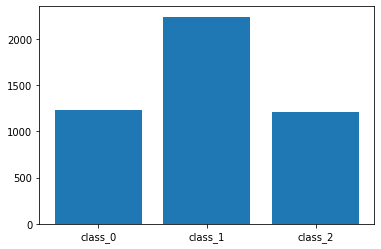

In [ ]:
class_0=class_1=class_2=0

for i in labels:
  if i=='0':
    class_0 += 1
  elif i=='1':
    class_1 += 1
  else:
    class_2 += 1

plt.subplot(111)
plt.bar(['class_0','class_1','class_2'],[class_0, class_1, class_2])
plt.show()

In [ ]:
train_imgs = []
for i in range(img_name.size):
  img = Image.open('/content/drive/MyDrive/Xrays/train_images/{train_image}'.format(train_image=img_name[i]))
  train_imgs.append(img)

print("Loaded Training data")

Loaded Training data


In [ ]:
for i in range(img_name.size):
  train_imgs[i]= resize(train_imgs[i], width, height)

In [ ]:
for i in range(img_name.size):
  train_imgs[i]= np.asarray(train_imgs[i])

In [ ]:
train_imgs = np.array(train_imgs, dtype="float32")/255.0

print(train_imgs.shape)

(4672, 150, 150, 3)


In [ ]:
depth = 20

num_classes = 3

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(train_imgs,labels, test_size=0.3)

input_shape = x_train.shape[1:]

x_train_mean = np.mean(x_train, axis=0)
#print('x_train_mean:',x_train_mean)
x_train -= x_train_mean
x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

t_train = keras.utils.to_categorical(y_train, num_classes)
t_test = keras.utils.to_categorical(y_test, num_classes)

print('y_train (labels) shape:', y_train.shape)
print('t_train (one-hot rep) shape:', t_train.shape)

x_train shape: (3270, 150, 150, 3)
3270 train samples
1402 test samples
y_train (labels) shape: (3270,)
t_train (one-hot rep) shape: (3270, 3)


In [ ]:
print(y_test)
print(t_test)
print(y_train)
print(t_train)
print(input_shape)

In [ ]:
#Idk which one works 
train_imgs = []
train_imgs = None
del train_imgs
labels = []
labels = None
del labels

y_test = []
y_test = None
del y_test

y_train = []
y_train = None
del y_train

#Trying to release memory

In [ ]:
def dense_block(x, nb_layers, nb_channels, growth_rate, dropout_rate=None, bottleneck=False, weight_decay=1e-4):
    """
    Creates a dense block and concatenates inputs
    """
    
    x_list = [x]
    for i in range(nb_layers):
        cb = convolution_block(x, growth_rate, dropout_rate, bottleneck, weight_decay)
        x_list.append(cb)
        x = Concatenate(axis=-1)(x_list)
        nb_channels += growth_rate
    return x, nb_channels

def convolution_block(x, nb_channels, dropout_rate=None, bottleneck=False, weight_decay=1e-4):
    """
    Creates a convolution block consisting of BN-ReLU-Conv.
    Optional: bottleneck, dropout
    """
    
    # Bottleneck
    if bottleneck:
        bottleneckWidth = 4
        x = BatchNormalization(gamma_regularizer=l2(weight_decay), beta_regularizer=l2(weight_decay))(x)
        x = Activation('relu')(x)
        x = Conv2D(nb_channels * bottleneckWidth, (1, 1), use_bias=False, kernel_regularizer=l2(weight_decay))(x)
        # Dropout
        if dropout_rate:
            x = Dropout(dropout_rate)(x)
    
    # Standard (BN-ReLU-Conv)
    x = BatchNormalization(gamma_regularizer=l2(weight_decay), beta_regularizer=l2(weight_decay))(x)
    x = Activation('relu')(x)
    x = Conv2D(nb_channels, (3, 3), padding='same', use_bias=False, kernel_regularizer=l2(weight_decay))(x)
    
    # Dropout
    if dropout_rate:
        x = Dropout(dropout_rate)(x)
    
    return x

def transition_layer(x, nb_channels, dropout_rate=None, compression=1.0, weight_decay=1e-4):
    """
    Creates a transition layer between dense blocks as transition, which do convolution and pooling.
    Works as downsampling.
    """
    
    x = BatchNormalization(gamma_regularizer=l2(weight_decay), beta_regularizer=l2(weight_decay))(x)
    x = Activation('relu')(x)
    x = Conv2D(int(nb_channels*compression), (1, 1), padding='same',
                      use_bias=False, kernel_regularizer=l2(weight_decay))(x)
    
    # Adding dropout
    if dropout_rate:
        x = Dropout(dropout_rate)(x)
    
    x = AveragePooling2D((2, 2), strides=(2, 2))(x)
    return x

In [ ]:
def DenseNet(input_shape=None, dense_blocks=3, dense_layers=-1, growth_rate=12, nb_classes=None, dropout_rate=None,
             bottleneck=False, compression=1.0, weight_decay=1e-4, depth=40):

  """
  Creating a DenseNet
  
  Arguments:
      input_shape  : shape of the input images. E.g. (28,28,1) for MNIST    
      dense_blocks : amount of dense blocks that will be created (default: 3)    
      dense_layers : number of layers in each dense block. You can also use a list for numbers of layers [2,4,3]
                      or define only 2 to add 2 layers at all dense blocks. -1 means that dense_layers will be calculated
                      by the given depth (default: -1)
      growth_rate  : number of filters to add per dense block (default: 12)
      nb_classes   : number of classes
      dropout_rate : defines the dropout rate that is accomplished after each conv layer (except the first one).
                      In the paper the authors recommend a dropout of 0.2 (default: None)
      bottleneck   : (True / False) if true it will be added in convolution block (default: False)
      compression  : reduce the number of feature-maps at transition layer. In the paper the authors recommend a compression
                      of 0.5 (default: 1.0 - will have no compression effect)
      weight_decay : weight decay of L2 regularization on weights (default: 1e-4)
      depth        : number or layers (default: 40)
      
  Returns:
      Model        : A Keras model instance
  """

  if nb_classes==None:
    raise Exception('Please define number of classes (e.g. num_classes=10). This is required for final softmax.')
    
  if compression <=0.0 or compression > 1.0:
    raise Exception('Compression have to be a value between 0.0 and 1.0. If you set compression to 1.0 it will be turn off.')
    
  dense_layers = (depth - (dense_blocks + 1))//dense_blocks
  
        
  img_input = Input(shape=input_shape)
  nb_channels = growth_rate * 2
    
  print('Creating DenseNet')
  print('#############################################')
  print('Dense blocks: %s' % dense_blocks)
  print('Layers per dense block: %s' % dense_layers)
  print('#############################################')
  
  # Initial convolution layer
  x = Conv2D(nb_channels, (3,3), padding='same',strides=(1,1),
                    use_bias=False, kernel_regularizer=l2(weight_decay))(img_input)
  
  # Building dense blocks
  for block in range(dense_blocks):
      
      # Add dense block
      x, nb_channels = dense_block(x, dense_layers, nb_channels, growth_rate, dropout_rate, bottleneck, weight_decay)
      
      if block < dense_blocks - 1:  # if it's not the last dense block
          # Add transition_block
          x = transition_layer(x, nb_channels, dropout_rate, compression, weight_decay)
          nb_channels = int(nb_channels * compression)
  
  x = BatchNormalization(gamma_regularizer=l2(weight_decay), beta_regularizer=l2(weight_decay))(x)
  x = Activation('relu')(x)
  x = GlobalAveragePooling2D()(x)
  
  x = Dense(nb_classes, activation='softmax', kernel_regularizer=l2(weight_decay), bias_regularizer=l2(weight_decay))(x)

  return Model(inputs = img_input, outputs = x)

In [ ]:
def lr_schedule(epoch):
  lr = 1e-2
  if (epoch>180) :
      lr *= 0.5e-3
  elif epoch > 160:
      lr *= 1e-3
  elif epoch > 120:
      lr *= 1e-2
  elif epoch > 80:
      lr *= 1e-1
  return lr

In [ ]:
class MyCallback(keras.callbacks.Callback):
    tstart = None
    def on_train_begin(self, logs={}):
        return
    
    def on_train_end(self, logs={}):
        return
    
    def on_epoch_begin(self, epoch, logs={}):
        self.tstart = time.time()
        print('epoch:{:03d}'.format(epoch+1), end=', ')
        return
    
    def on_epoch_end(self, epoch, logs={}):
        print('loss:{:8.6f}, acc:{:8.6f},  val_loss:{:8.6f}, val_acc:{:8.6f},  val_acc-acc = {:5.2f}%,  lr:{:0.6f}  [{:0.2f} sec]'.format(
                logs.get('loss'), logs.get('acc'),
                logs.get('val_loss'), logs.get('val_acc'),
                100*(logs.get('val_acc')-logs.get('acc')),
                K.eval(self.model.optimizer.lr),
                time.time()-self.tstart))
        return
    
    def on_batch_begin(self, batch, logs={}):
        return
    
    def on_batch_end(self, batch, logs={}):
        return

In [ ]:
model = DenseNet(input_shape=input_shape, nb_classes=num_classes, depth=depth)
    
model.compile(loss="categorical_crossentropy",
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['acc'])
model.summary()

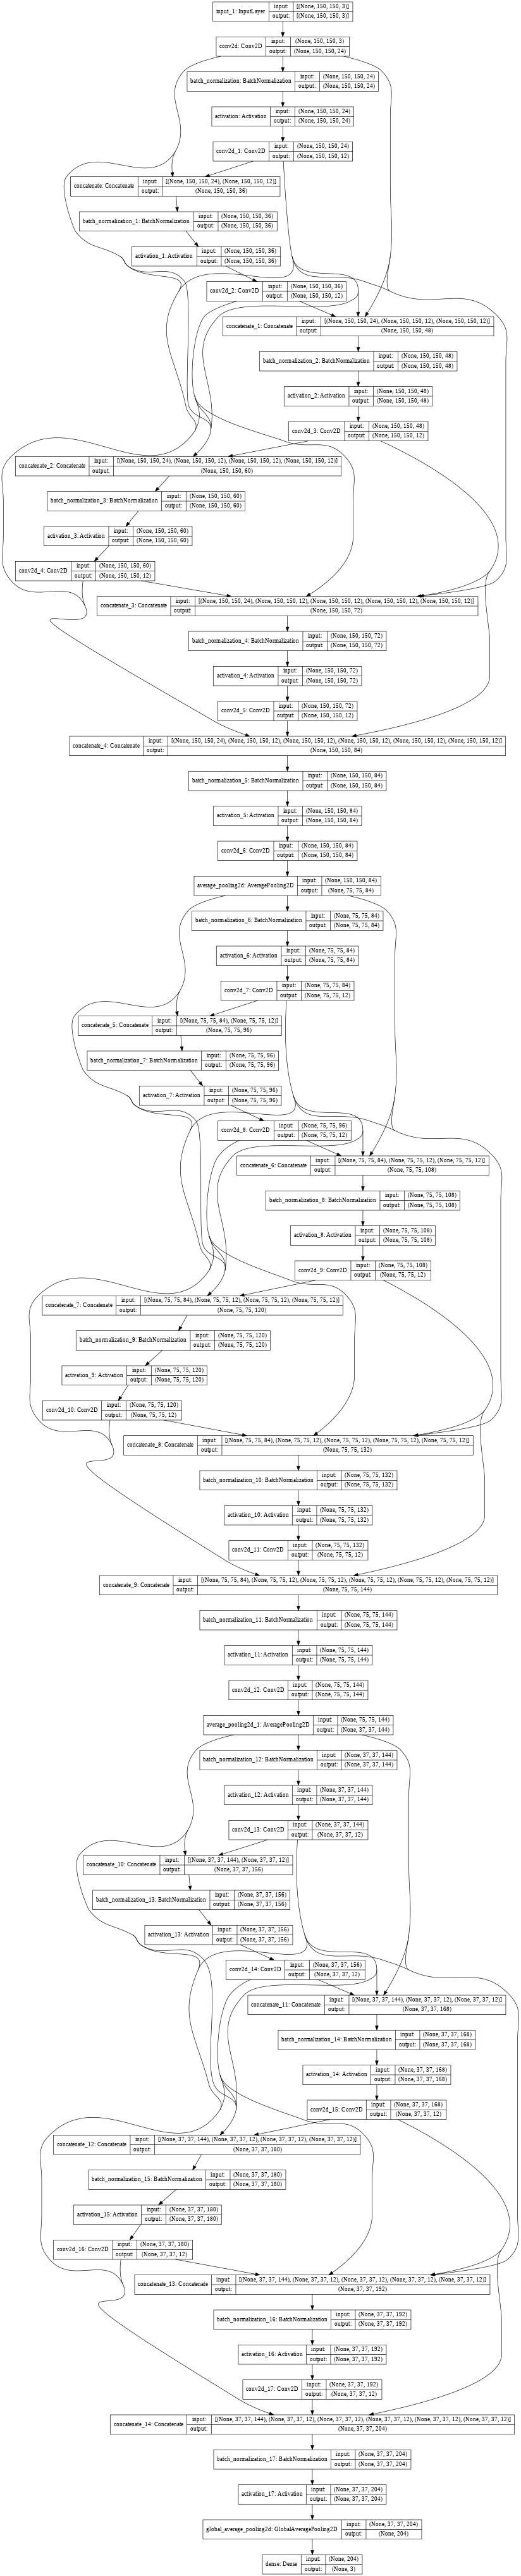

In [ ]:
plot_model(model, show_shapes=True, dpi=48)

In [ ]:
# Training parameters
batch_size = 32  # orig paper trained all networks with batch_size=128
epochs = 200

# Prepare model model saving directory.
model_name = 'densenet20-e{epoch:04d}-loss{loss:.3f}-acc{acc:.3f}-valloss{val_loss:.3f}-valacc{val_acc:.3f}.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
  featurewise_center=False,  # set input mean to 0 over the dataset
  samplewise_center=False,  # set each sample mean to 0
  featurewise_std_normalization=False,  # divide inputs by std of the dataset
  samplewise_std_normalization=False,  # divide each input by its std
  zca_whitening=False,  # apply ZCA whitening
  rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
  zoom_range = 0.2, # Randomly zoom image 
  width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
  height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
  horizontal_flip = True,  # randomly flip images
  vertical_flip=False)  # randomly flip images

# Compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied).

datagen.fit(x_train)


# Fit the model on the batches generated by datagen.flow().
history = model.fit(datagen.flow(x_train, t_train, batch_size=batch_size*2), 
                    validation_data=(x_test, t_test), epochs=epochs, verbose=0, 
                    workers=4, steps_per_epoch = int(x_train.shape[0]/batch_size), 
                    callbacks=[lr_reducer, lr_scheduler, MyCallback(), checkpoint])

# Score trained model.
scores = model.evaluate(x_test, t_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel('Epochs')
plt.ylabel('%')
plt.legend(('acc','val-acc'))
plt.grid(b=True)

In [ ]:
#print(x_train_mean)

np.save('mean.npy', x_train_mean)

In [ ]:
#Idk which one works 
x_train = []
x_train = None
del x_train
t_train = []
t_train = None
del t_train

x_test = []
x_test = None
del x_test

t_test = []
t_test = None
del t_test

datagen = None
del datagen

history = None
del history
#Trying to release memory

In [ ]:
test_imgs_paths = os.listdir('/content/drive/MyDrive/Xrays/test_images/')
test_imgs = []
for path in test_imgs_paths:
  img = Image.open('/content/drive/MyDrive/Xrays/test_images/{test_image}'.format(test_image=path))
  test_imgs.append(img)

print("Loaded Test data")

Loaded Test data


In [ ]:
for i in range(len(test_imgs_paths)):
  test_imgs[i]= resize(test_imgs[i], width, height)
  test_imgs[i]= np.asarray(test_imgs[i])

test_imgs = np.array(test_imgs, dtype="float32")/255.0

print(test_imgs.shape)

(1168, 150, 150, 3)


In [ ]:
test_imgs -= x_train_mean

#test_imgs_mean = np.mean(test_imgs, axis=0)
#test_imgs -= test_imgs_mean

In [ ]:
predictions = model.predict(test_imgs)

In [ ]:
def getMaxIndex(list):
  maxim= max(list)
  for i in range(len(list)):
    if maxim == list[i]:
      return i

In [ ]:
import csv

with open('submission_densenet20_150p.csv', mode='w') as submission_file:
    submission_file = csv.writer(submission_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

    submission_file.writerow(['file_name', 'class_id'])
    j=0
    for i  in predictions:
      #print("image : {img} \t\tclass : {i}".format(img=test_imgs_paths[j], i=getMaxIndex(i)))
      submission_file.writerow(['{img}'.format(img=test_imgs_paths[j]), '{i}'.format(i=getMaxIndex(i))])
      j+=1

print("Done")